# Non-linear Regression

- The truth is not always linear


## Polynomial regression

$$
y_1=\beta_0+\beta_1x_1 + \beta_2x_1^2+\beta_3x_1^3+...+\beta_dx_1^d+e
$$

![image-2.png](./img/52.png)


## Step Function

- Using polynomial functions of the features as predictors in a linear model imposes a **global structure on the non-linear** function of X.
- We can instead use `step functions` in order to avoid imposing such a global structure.
  - This amounts to **converting a `continuous` variable into an `ordered` `categorical` variable.**

![image.png](./img/53.png)

- Divide the target variable into discrete classes
  - Can use `Breakpoint` test statistics to help this transforming.

![image.png](./img/54.png)


## Break Point Statistics

1. `Breakpoint checking` is a statistical technique used to identify `structural changes` or `breakpoints` in data series.
2. These changes could indicate shifts in underlying processes, trends, or relationships within the data.

### Chow Test

- The chow test statistic is calculated as follows:
  - $RSS_r$ is the residual sum of squares from the model with all data combined.
  - $RSS_1$ and $RSS_2$ are the residual sum of squares from the separate models for each segment.
  - $k$ is the number of parameters estimated in each segment.
  - $n_1$ and $n_2$ are the number of observations in each segment
    $$
    F=\frac{RSS_r-(RSS_1+RSS_2)/k}{(RSS_1+RSS_2)/(n_1+n_2-2k)}
    $$


In [3]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [6]:
# Generate two sections of data with different linear functions
np.random.seed(0)

# First section
n1 = 50
x1 = np.linspace(0, 5, n1)
y1 = 2 * x1 + np.random.normal(0, 1, n1)

# Second section
n2 = 50
x2 = np.linspace(5, 10, n2)
y2 = 3 * x2 + np.random.normal(0, 1, n2)

# Merge the sections
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])

# Initialize variables to store best breakpoint and test statistic
best_breakpoint = None
best_F = 0

# Iterate over potential breakpoints
for i in range(1, len(x)-1):
    x1 = x[:i]
    y1 = y[:i]
    x2 = x[i:]
    y2 = y[i:]
    
    # Fit model with all data combined
    X_combined = sm.add_constant(np.concatenate([x1, x2]))
    model_combined = sm.OLS(np.concatenate([y1, y2]), X_combined).fit()
    RSS_r = model_combined.ssr
    k = 2  # Number of parameters estimated in each segment
    
    # Fit separate models for each segment
    model1 = sm.OLS(y1, sm.add_constant(x1)).fit()
    model2 = sm.OLS(y2, sm.add_constant(x2)).fit()
    RSS_1 = model1.ssr
    RSS_2 = model2.ssr
    n1 = len(x1)
    n2 = len(x2)
    
    # Calculate Chow test statistic
    F_chow = ((RSS_r - (RSS_1 + RSS_2)) / k) / ((RSS_1 + RSS_2) / (n1 + n2 - 2*k))
    
    # Update best breakpoint if necessary
    if F_chow > best_F:
        best_F = F_chow
        best_breakpoint = i

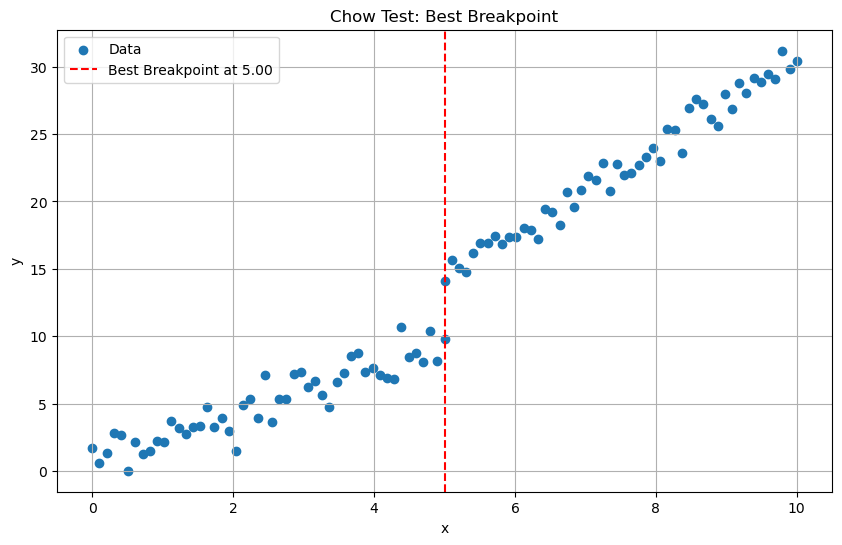

Best Breakpoint: 5.0
Chow Test Statistic: 157.58585701856043


In [7]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data')
plt.axvline(x=x[best_breakpoint], color='r', linestyle='--', label=f'Best Breakpoint at {x[best_breakpoint]:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Chow Test: Best Breakpoint')
plt.legend()
plt.grid(True)
plt.show()

print("Best Breakpoint:", x[best_breakpoint])
print("Chow Test Statistic:", best_F)

### Bai-Perron Test

- It uses a `dynamic programming` approach to efficiently identify the number and locations of breakpoints by minimizing the sum of squared residuals.
- Steps:
  1. Let $y_t = X_t^T β_j + ε_t$ be the linear regression model with $m$ breakpoints
  2. sup $F_T(λ_1, ..., λ_m)$, where $λ_j = T_j/T$ are the breakpoint fractions
     - And $F_T$ is a function of the `sum of squared residuals` for different partitions of the sample.


In [11]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

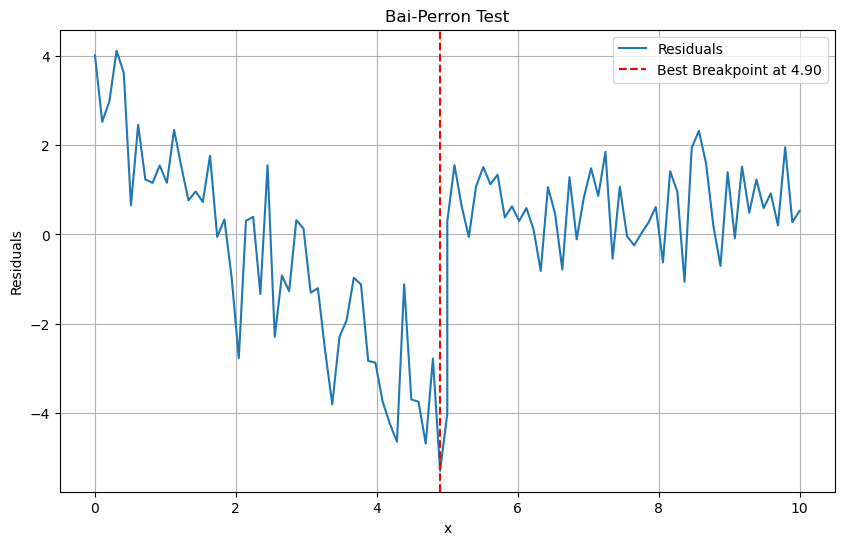

In [26]:
# Fit the model
X_combined = sm.add_constant(x)
model_combined = sm.OLS(y, X_combined).fit()
residuals = model_combined.resid

# Perform Bai-Perron Test
breakpoints = breaks_cusumolsresid(residuals)

# Visualize Bai-Perron Test
plt.figure(figsize=(10, 6))
plt.plot(x, residuals, label='Residuals')
plt.axvline(x=x[np.argmin(residuals)], color='r', linestyle='--', label=f'Best Breakpoint at {x[np.argmin(residuals)]:.2f}')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('Bai-Perron Test')
plt.legend()
plt.grid(True)
plt.show()

# print("Detected Breakpoints:", [x[bp] for bp in breakpoints])

## Regression Splines

### Piecewise Polynomials

- Step function + Polynomials regression

![image.png](./img/61.png)

- Put the constraint on Piecewise Cubic
  - Green line (2nd plot) force the function to be continuous
  - Red line (3rd plot) add constraint of 2nd derivatives (convex)

![image.png](./img/55.png)


### Liner Splines

- A linear spline with knots at $k=1,...,K$ is a piecewise linear polynomial continuous at each knot.
  - where the $b_k$ are basis functions
    $$
    y_i = \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i)+...+\beta_Kb_K(x_i) + e_i
    $$


### Smoothing Splines

- It consider the following criterion for fitting a smooth function $g(x)$ to data:
  - The first term is RSS, and try to make $g(x)$ match the data at each $x$
  - The second term is 2nd derivatives, it constraint the smoothness \* **$\lambda$ is the tuning parameter**, when $\lambda$ goes infinity, the 2nd derivatives has to be 0, which means a linear function （No Concave-Convexity）
    $$
    minimize_{g\in S} \sum_{i=1}^n(y_i-g(x_i))^2+\lambda \int g''(t)^2dt
    $$

![image.png](./img/56.png)


## Generalized Additive Models and Local Regression

### Local Regression

![image.png](./img/57.png)

### Generalized Additive Models

![image.png](./img/58.png)

![image.png](./img/59.png)

![image.png](./img/60.png)
